# Spike-Driven Synaptic Plasticity

In this tutorial, we will reproduce Figure 2(c) from the paper.

## Preliminaries: Set up Weight Update model and Neuron model

We looked at the weight update model and neuron model in the previous tutorial. If you haven't completed the first tutorial, this is a good moment to check out its "Preliminaries" section before proceeding with the rest of this tutorial. <br>

Below, we import the weight update and neuron models, just as we did in the first tutorial.

In [1]:
from models.synapses.fusi import fusi_model, FUSI_PARAMS, fusi_init, fusi_post_init
from models.neurons.integrate_fire import if_model, IF_PARAMS, if_init

## Part II: Reproducing Figure 2(c)

As we mentioned at the end of our previous tutorial, when `X` starts at 0 and crosses the threshold &theta;<sub>X</sub> to the other side, it is called a Long Term Potentiation (LTP) transition. Figure 2(c) shows the probability of a LTP transition as a function of v<sub>post</sub>. Each curve on the graph corresponds to a different value of v<sub>pre</sub>. <br>

To reproduce this figure, we simply need to do several runs of the above simulation script, iterating over different combinations of v<sub>pre</sub> and v<sub>post</sub>. Note that we don't directly set v<sub>post</sub>; we use the weights from `extra_poisson` to `postsyn` to control v<sub>post</sub>. <br>

Ideally, you should perform this experiment on a GPU, and the complete script can be found in [this Google Colab notebook](https://colab.research.google.com/drive/106dPA8pOJkK3gQSJ4fVqggOq_WlUFpcK). Below, you can see an example of how to read in each of the CSV files and plot the results. <br>

First, we create a DataFrame and populate it with the data from each csv file.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

csv_dir = "/home/manvi/Documents/pygenn_ml_tutorial/fusi_data/LTP" # change this to the target directory
csv_list = [i for i in os.listdir(csv_dir) if i[-3:] == "csv"]
csv_list.sort()
df = pd.DataFrame(columns=["pre_spike_rate", "post_spike_rate", "LTP_success"])

for f in csv_list:
    f_path = os.path.join(csv_dir, f)
    print("Processing " + f)
    pre_spike_rate = f[:2]
    temp_df = pd.read_csv(f_path)
    temp_df["pre_spike_rate"] = pre_spike_rate
    df = df.append(temp_df)
    
df.post_spike_rate = df.post_spike_rate.round(2)

Processing 20.0_0.03.csv
Processing 20.0_0.04.csv
Processing 20.0_0.05.csv
Processing 20.0_0.06.csv
Processing 20.0_0.07.csv
Processing 20.0_0.08.csv
Processing 30.0_0.03.csv
Processing 30.0_0.04.csv
Processing 30.0_0.05.csv
Processing 30.0_0.06.csv
Processing 30.0_0.07.csv
Processing 30.0_0.08.csv
Processing 40.0_0.03.csv
Processing 40.0_0.04.csv
Processing 40.0_0.05.csv
Processing 40.0_0.06.csv
Processing 40.0_0.07.csv
Processing 40.0_0.08.csv
Processing 50.0_0.03.csv
Processing 50.0_0.04.csv
Processing 50.0_0.05.csv
Processing 50.0_0.06.csv
Processing 50.0_0.07.csv
Processing 50.0_0.08.csv


Then, we want to calculate the probability of obtaining a LTP transition for each combination of v<sub>pre</sub> and v<sub>post</sub>. We store the probabilities in `prob`, which is a dictionary containing v<sub>pre</sub> as the keys and v<sub>post</sub> and the corresponding probability as the values.

In [3]:
total = len(df.index)
all_post_rates = df.post_spike_rate.unique()
all_post_rates.sort()
pre_spike_rates = df.pre_spike_rate.unique()
pre_spike_rates.sort()
prob = dict()
for pre_rate in pre_spike_rates:
    
    print("Processing pre spike rate " + str(pre_rate) + " Hz.")
    prob[pre_rate] = [[],[]]
    
    rate_df = df[df["pre_spike_rate"] == pre_rate]
    post_spike_rates = rate_df.post_spike_rate.unique()
    
    for post_rate in all_post_rates:
        if post_rate in post_spike_rates:
            post_rate_df = rate_df[rate_df["post_spike_rate"] == post_rate]
            success_df = post_rate_df[post_rate_df["LTP_success"] == 1]
            success_count = len(success_df.index)
            prob[pre_rate][0].append(post_rate)
            prob[pre_rate][1].append(success_count / total)

Processing pre spike rate 20 Hz.
Processing pre spike rate 30 Hz.
Processing pre spike rate 40 Hz.
Processing pre spike rate 50 Hz.


Finally, we are ready to create the plot!

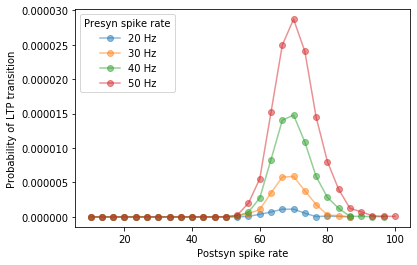

In [4]:
fig, ax = plt.subplots()
for pre_rate in prob.keys():
    ax.plot(prob[pre_rate][0], prob[pre_rate][1], 'o-', label=str(pre_rate)+" Hz", alpha=0.5)
leg = ax.legend(title="Presyn spike rate")
ax.set_xlabel("Postsyn spike rate")
ax.set_ylabel("Probability of LTP transition")
plt.show()